<a href="https://colab.research.google.com/github/gargomaniz/projet_mesure_carton/blob/main/ProjetCartons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from numpy import asarray

from PIL import Image

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns

print("Tensorflow version " + tf.__version__)


Tensorflow version 2.4.0


<a name="1: data intructions"></a>
## Set up the data location


- Go to this google drive folder named [Box Data Projet Mesure Carton](https://drive.google.com/drive/folders/1mXz_wjkzrDoYP7GQqe1U5MugnVQKvnWq?usp=sharing)
- Next to the folder name "Box Data Projet Mesure Carton", hover your mouse over the triangle to reveal the drop down menu. 
- Use the drop down menu to select `"Add shortcut to Drive"`  A pop-up menu will open up. 
- In the pop-up menu, "My Drive" is selected by default.  Click the `ADD SHORTCUT` button. This should add a shortcut to the folder `Box Data Projet Mesure Carton` within your own google drive at the location `content/drive`.
- To verify, go to the left-side menu and click on "My Drive".  Scroll through your files to look for the shortcut 'Box data projet mesure carton' Data. 

<a name="0-4"></a>
## Mount your drive

Please run the next code cell and follow these steps to mount your Google Drive so that it can be accessed by this Colab.
- Run the code cell below.  A web link will appear below the cell.
- Please click on the web link, which will open a new tab in your browser, which asks you to choose your google account.
- Choose your google account to login.
- The page will display "Google Drive File Stream wants to access your Google Account".  Please click "Allow".
- The page will now show a code (a line of text).  Please copy the code and return to this Colab.
- Paste the code the textbox that is labeled "Enter your authorization code:" and hit `<Enter>`
- The text will now say "Mounted at /content/drive/"

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)


Mounted at /content/drive/


In [3]:
image = Image.open('/content/drive/MyDrive/BoxDataProjetMesureCarton/test_masks/00371fbc0d38eab5_m025dyy_18f279ee.png')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:

height = 720
width = 1280


In [5]:
mask = tf.io.read_file('/content/drive/MyDrive/BoxDataProjetMesureCarton/test_masks/00371fbc0d38eab5_m025dyy_18f279ee.png')

annotation = tf.image.decode_png(mask, channels = 1, dtype = tf.uint8)

annotation = tf.image.resize(annotation, (height, width, ))

annotation = tf.cast(annotation, dtype=tf.int32)
annotation = tf.reshape(annotation, (height, width, 1, ))

print(annotation.shape)
print(annotation[600][0])  



(720, 1280, 1)
tf.Tensor([255], shape=(1,), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


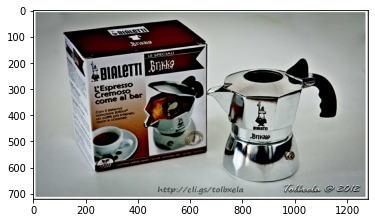

In [6]:


img_raw = tf.io.read_file('/content/drive/MyDrive/BoxDataProjetMesureCarton/test/06d3e8dbaa8580a9.jpg')

image = tf.image.decode_jpeg(img_raw)

image = tf.image.resize(image, (height, width,))

image = tf.reshape(image, (height, width, 3,))

image = image/127.5
image -= 1
plt.imshow(image)

In [7]:
class_names = ['box']

In [8]:
def map_filename_to_image_and_mask(t_filename, a_filename, height=720, width=1280):
  '''
  Preprocesses the dataset by:
    * resizing the input image and label maps
    * normalizing the input image pixels
    * reshaping the label maps from (height, width, 1) to (height, width, 12)

  Args:
    t_filename (string) -- path to the raw input image
    a_filename (string) -- path to the raw annotation (label map) file
    height (int) -- height in pixels to resize to
    width (int) -- width in pixels to resize to

  Returns:
    image (tensor) -- preprocessed image
    annotation (tensor) -- preprocessed annotation
  '''

  # Convert image and mask files to tensors 
  img_raw = tf.io.read_file(t_filename)
  anno_raw = tf.io.read_file(a_filename)
  image = tf.image.decode_jpeg(img_raw)
  annotation = tf.image.decode_png(anno_raw, channels = 1, dtype = tf.uint8)
 
  # Resize image and segmentation mask
  image = tf.image.resize(image, (height, width,))
  annotation = tf.image.resize(annotation, (height, width,))
  image = tf.reshape(image, (height, width, 3,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  annotation = tf.reshape(annotation, (height, width, 1,))
  stack_list = []

  # Reshape segmentation masks
  for c in range(len(class_names)):
    mask = tf.equal(annotation[:,:,0], tf.constant(c))
    stack_list.append(tf.cast(mask, dtype=tf.int32))
  
  annotation = tf.stack(stack_list, axis=2)
 
  # Normalize pixels in the input image
  image = image/127.5
  image -= 1

  return image, annotation

In [9]:
BATCH_SIZE = 200 # erreur car BATCH_SIZE n'etait pas défini

def get_dataset_slice_paths(image_dir, label_map_dir):
  '''
  generates the lists of image and label map paths
  
  Args:
    image_dir (string) -- path to the input images directory
    label_map_dir (string) -- path to the label map directory

  Returns:
    image_paths (list of strings) -- paths to each image file
    label_map_paths (list of strings) -- paths to each label map
  '''
  image_file_list = os.listdir(image_dir)
  label_map_file_list = os.listdir(label_map_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
  label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]

  return image_paths, label_map_paths


def get_training_dataset(image_paths, label_map_paths):
  '''
  Prepares shuffled batches of the training set.
  
  Args:
    image_paths (list of strings) -- paths to each image file in the train set
    label_map_paths (list of strings) -- paths to each label map in the train set

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  training_dataset = training_dataset.map(map_filename_to_image_and_mask)
  training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset


def get_validation_dataset(image_paths, label_map_paths):
  '''
  Prepares batches of the validation set.
  
  Args:
    image_paths (list of strings) -- paths to each image file in the val set
    label_map_paths (list of strings) -- paths to each label map in the val set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()  

  return validation_dataset

In [10]:
training_image_paths, training_label_map_paths = get_dataset_slice_paths('/content/drive/MyDrive/data_combined/ImagesTrain','/content/drive/MyDrive/data_combined/new_train')
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths('/content/drive/MyDrive/data_combined/ImagesVal','/content/drive/MyDrive/data_combined/new_validation')

# generate the train and val sets
training_dataset = get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)



In [11]:
# generate a list that contains one color for each class
colors = sns.color_palette(None, len(class_names))


In [12]:
# Visualization Utilities

def fuse_with_pil(images):
  '''
  Creates a blank image and pastes input images

  Args:
    images (list of numpy arrays) - numpy array representations of the images to paste
  
  Returns:
    PIL Image object containing the images
  '''

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]
  
  return new_im


def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array
  
  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(3) :
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[0][c] * 255.0)
    seg_img[:,:,1] += segc*( colors[0][c] * 255.0)
    seg_img[:,:,2] += segc*( colors[0][c] * 255.0)

  
  return seg_img


def show_predictions(image, labelmaps, titles, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps

  Args:
    image (numpy array) -- the input image
    labelmaps (list of arrays) -- contains the predicted and ground truth label maps
    titles (list of strings) -- display headings for the images to be displayed
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each vlass
  '''

  true_img = give_color_to_annotation(labelmaps[1])
  pred_img = give_color_to_annotation(labelmaps[0])

  image = image + 1
  image = image * 127.5
  images = np.uint8([image, pred_img, true_img])

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list) 

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.title(titles[idx], fontsize=12)
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  '''
  Displays the image and its annotation side by side

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the label map
  '''
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)
 

  image = image + 1
  image = image * 127.5
  image = np.uint8(image)
  images = [image, seg_img]
  
  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)
  

def list_show_annotation(dataset):
  '''
  Displays images and its annotations side by side

  Args:
    dataset (tf Dataset) - batch of images and annotations
  '''

  ds = dataset.unbatch()
  ds = ds.shuffle(buffer_size=100)

  plt.figure(figsize=(25, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  # we set the number of image-annotation pairs to 9
  # feel free to make this a function parameter if you want
  for idx, (image, annotation) in enumerate(ds.take(9)):
    plt.subplot(3, 3, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())



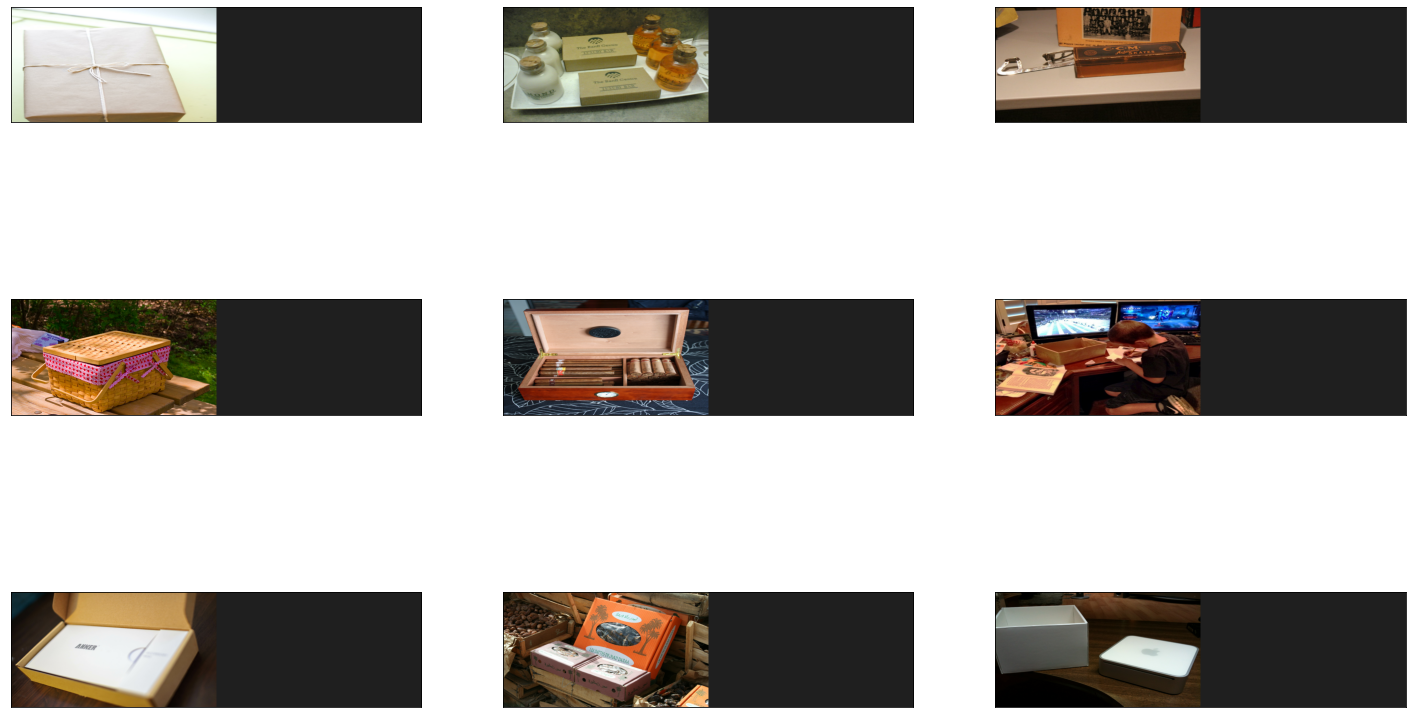

In [16]:
list_show_annotation(training_dataset)

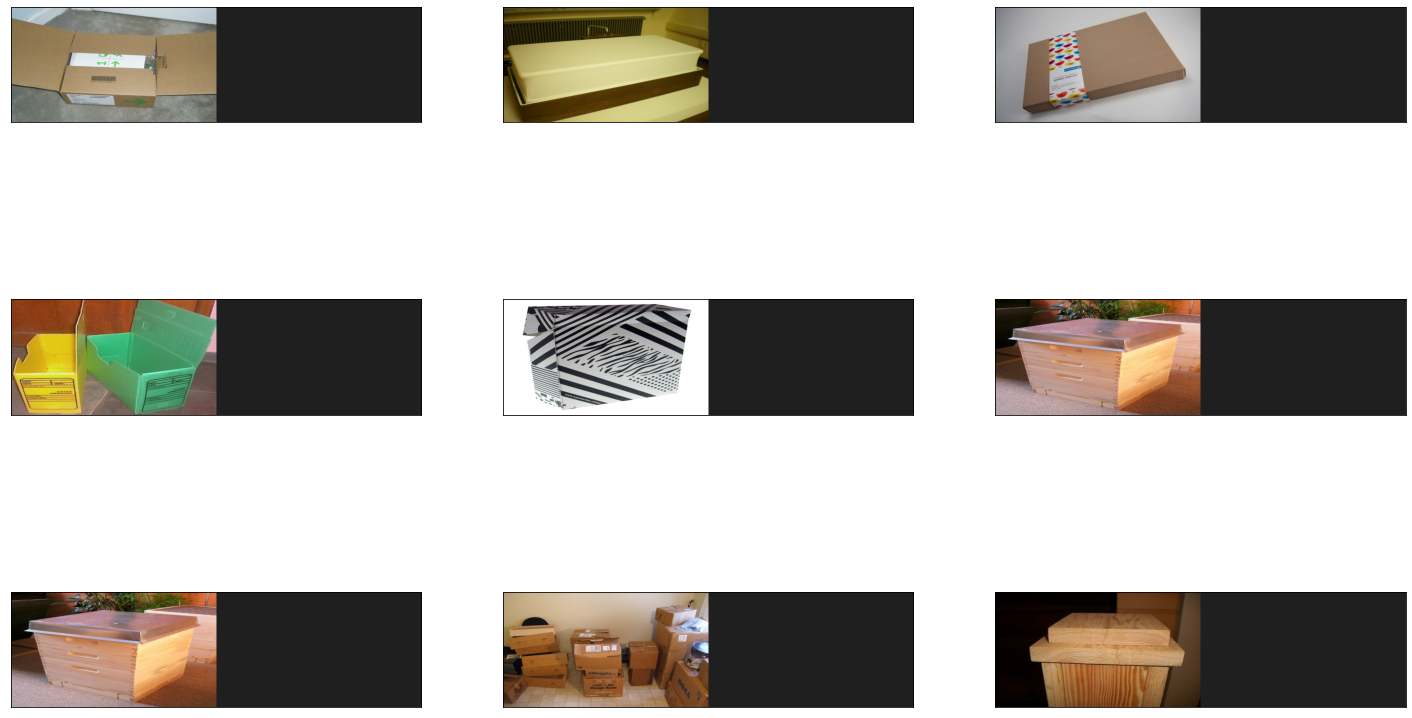

In [14]:
list_show_annotation(validation_dataset)